# RESUME CLASSIFICATION USING MACHINE LEARNING

In [1]:
# importing required libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import re
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\HP\Desktop\Data Science\Datasets\Resumes Dataset\UpdatedResumeDataSet.csv')
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


* **Some documents are consider as bad data because they contain irrelevant special characters. These special characters are often introduced when the data is stored in a database and then retrieved from the database. When a resume is stored, it is typically correct and fine. However, when the resume is retrieved from the database, the special characters may be introduced, which can make the resume invalid.**


* **We first apply text pre-processing steps to clean the data then apply feature encoding techniques and in last we perform model building.**

In [3]:
df.shape

(962, 2)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [5]:
df.isnull().sum()

Category    0
Resume      0
dtype: int64

In [6]:
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [7]:
df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64

In [8]:
df['Category'].nunique()

25

**Dataset contains 25 different categories of resumes.**

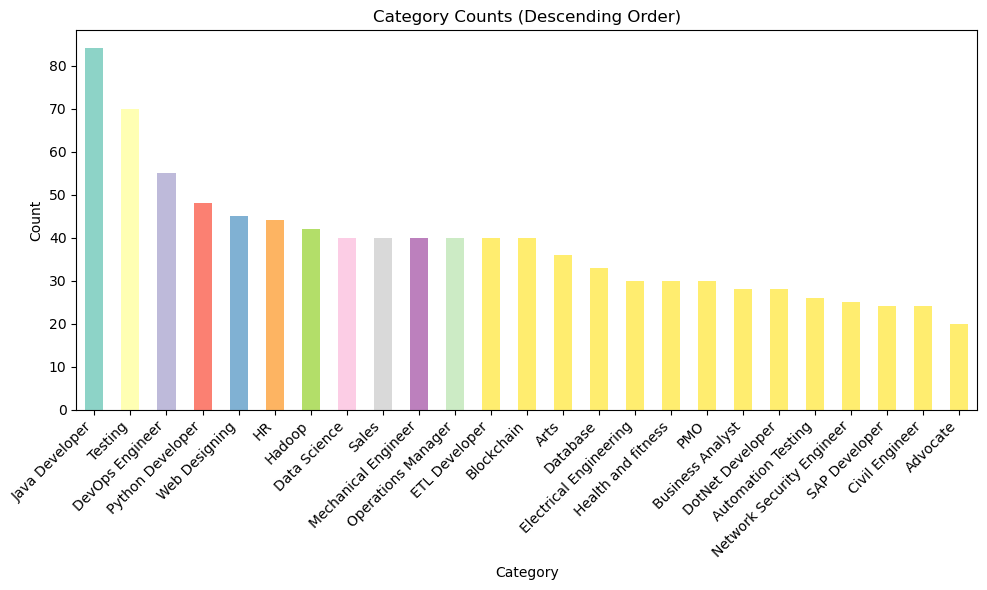

In [9]:
category_counts = df['Category'].value_counts()

# Sort the categories in descending order based on their counts
category_counts_sorted = category_counts.sort_values(ascending=False)

# Create a colorful bar plot with different colors for each category
plt.figure(figsize=(10, 6))
colors = plt.cm.Set3(range(len(category_counts_sorted)))
category_counts_sorted.plot(kind='bar', color=colors)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts (Descending Order)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

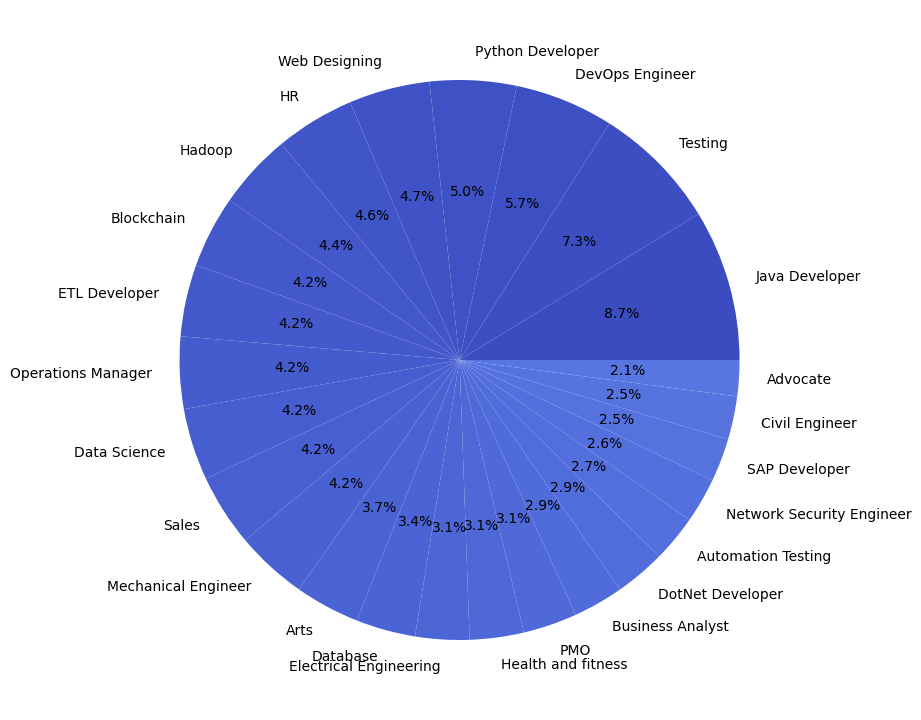

In [10]:
# Count occurrences of each category
targetCounts = df['Category'].value_counts()
targetLabels = targetCounts.index

# Create a colorful pie chart
plt.figure(1, figsize=(20, 20))
theGrid = GridSpec(2, 2)
cmap = plt.get_cmap('coolwarm')
colors = [cmap(i) for i in range(len(targetCounts))]

plt.subplot(theGrid[0, 1], aspect=1)
sourcePie = plt.pie(targetCounts, labels=targetLabels, colors=colors, autopct='%.1f%%')

plt.show()

# Data Cleaning / Text Pre-processing

## 1) Convert uppercase into lower case

In [11]:
df['Resume'] = df['Resume'].str.lower()
df['Resume']

0      skills * programming languages: python (pandas...
1      education details \r\nmay 2013 to may 2017 b.e...
2      areas of interest deep learning, control syste...
3      skills â¢ r â¢ python â¢ sap hana â¢ table...
4      education details \r\n mca   ymcaust,  faridab...
                             ...                        
957    computer skills: â¢ proficient in ms office (...
958    â willingness to accept the challenges. â ...
959    personal skills â¢ quick learner, â¢ eagerne...
960    computer skills & software knowledge ms-power ...
961    skill set os windows xp/7/8/8.1/10 database my...
Name: Resume, Length: 962, dtype: object

## 2) Remove URL's, Hastags, special characters, punctuation marks, blank spaces, newlines,non-ASCII Characters, Leading/trailing spaces.

ASCII characters are all the characters that have a number associated with them. This number is used to store the character in a computer system. ASCII characters include letters, numbers, symbols, emojis, and punctuation marks. Each ASCII character is represented by a specific number between 0 and 127. This means that there are 128 different ASCII characters. The number 0 represents the character "NUL", the number 1 represents the character "SOH", and so on.

Remove URLs, hashtags, special characters, punctuation marks, blank spaces, newlines, and leading/trailing spaces from the words to make the data simpler and easier to understand for NLP tasks. These characters often don't have much meaning in NLP tasks, so removing them can help to improve the performance of the model.

In [12]:
def cleanResume(resumeText):
    resumeText = re.sub(r'http\S+', '', resumeText)  # Remove URLs 
    resumeText = re.sub(r'#\S+', '', resumeText)  # Remove hashtags
    resumeText = re.sub(r'[^A-Za-z0-9\s.]', '', resumeText)  # Remove special characters (except full stop) 
    resumeText = re.sub(r'(?<!\w)\.(?=\s)', '', resumeText)  # Remove special characters except full stop (with space after)
    resumeText = re.sub(r'[^\w\s.]', '', resumeText)
    resumeText = re.sub(r'\s+', ' ', resumeText).strip()  # Remove extra spaces
    resumeText = resumeText.replace('\n', ' ')  # Remove newlines
    return resumeText

    return resumeText

**I removed all punctuation marks except full stops (.) from the text in the resume because degrees are written like "B.Com", "B.Sc", "B.Tech", etc. If the full stop is removed, the words will be separated into two parts, such as "B" and "Com", which do not have any semantic meaning.**

In [13]:
resumeText = "Hello, this résumé contains non-ASCII characters."
modifiedText = re.sub(r'[^\x00-\x7f]+', r'', resumeText)
print(modifiedText)

Hello, this rsum contains non-ASCII characters.


**é, é these are called non-ASCII characters.**

In [14]:
df['cleaned resume'] = df['Resume'].apply(lambda x: cleanResume(x))

In [15]:
# 30th record of dataset

print(df['cleaned resume'][30])

skills programming languages python pandas numpy scipy scikitlearn matplotlib sql java javascriptjquery. machine learning regression svm nave bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets. database visualizations mysql sqlserver cassandra hbase elasticsearch d3.js dc.js plotly kibana matplotlib ggplot tableau. others regular expression html css angular 6 logstash kafka python flask git docker computer vision open cv and understanding of deep learning.education details data science assurance associate data science assurance associate ernst young llp skill details javascript exprience 24 months jquery exprience 24 months python exprience 24 monthscompany details company ernst young llp description fraud investigations and dispute services assurance technology assisted review tar technology assisted review assists in accelerating the 

In [16]:
df.head()

,Category,Resume,cleaned resume
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b.e uit...
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...


**All the steps of text preprocessing is applied on corpus which we give in the user define function.**

In [17]:
# Check the no. of documents in dataset and maximum length of document 

sentLens = []

for i in df['cleaned resume']:
    length = len(i.split())
    sentLens.append(length)

print(len(sentLens))
print(max(sentLens))

962
2014


In [18]:
# Original Resume 

df['Resume'][100]

'skills: natural languages: proficient in english, hindi and marathi. computer skills: proficient with ms-office, internet operation.education details \r\njanuary 2015 to january 2018 llb law mumbai, maharashtra mumbai university\r\njanuary 2015 b.m.m  mumbai, maharashtra s.k.somaiya college, mumbai university\r\n h.s.c   asmita girls junior college, maharashtra board\r\n s.s.c vidya bhawan  maharashtra board\r\nadvocate \r\n\r\nllb student and journalist\r\nskill details \r\ncompany details \r\ncompany - criminal lawyer (law firm)\r\ndescription - '

In [19]:
# Cleaned Resume 

df['cleaned resume'][100]

'skills natural languages proficient in english hindi and marathi. computer skills proficient with msoffice internet operation.education details january 2015 to january 2018 llb law mumbai maharashtra mumbai university january 2015 b.m.m mumbai maharashtra s.k.somaiya college mumbai university h.s.c asmita girls junior college maharashtra board s.s.c vidya bhawan maharashtra board advocate llb student and journalist skill details company details company criminal lawyer law firm description'

# 3) Tokenization, removal of Stop words and punctuation marks

Break the text down into its smallest parts, like words and punctuation marks. This will make it easier for the model to understand the text.

In [20]:
setOFStopWords = set(stopwords.words('english'))
setOFStopWords

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

**List of stop words.**

In [21]:
import string

totalWords = []
setOfStopwords = set(stopwords.words('english'))

sentences = df['cleaned resume'].values
cleanedSent = ' '

for i in range(1, 160):
    cleanedText = cleanResume(sentences[i])
    cleanedSent += cleanedText

    requiredWords = nltk.word_tokenize(cleanedText)

    for word in requiredWords:
        if word not in setOfStopwords and word not in string.punctuation:
            totalWords.append(word)

wordFreqDist = nltk.FreqDist(totalWords)
mostCommon = wordFreqDist.most_common(50)
print(mostCommon)

[('details', 485), ('exprience', 443), ('data', 401), ('company', 393), ('months', 392), ('description', 357), ('1', 258), ('year', 247), ('project', 222), ('january', 216), ('learning', 205), ('science', 205), ('less', 204), ('skill', 183), ('maharashtra', 166), ('python', 162), ('6', 151), ('machine', 147), ('college', 146), ('arts', 144), ('university', 140), ('web', 134), ('development', 133), ('skills', 133), ('education', 126), ('like', 126), ('india', 120), ('management', 120), ('application', 120), ('analytics', 114), ('software', 110), ('team', 109), ('using', 109), ('business', 108), ('developed', 102), ('monthscompany', 101), ('time', 98), ('used', 97), ('experience', 96), ('mumbai', 96), ('knowledge', 94), ('projects', 93), ('sql', 91), ('engineering', 90), ('pune', 90), ('database', 87), ('analysis', 84), ('responsibilities', 84), ('hr', 84), ('technical', 80)]


**These are most occurring words in 'cleand resume' column.**

**Analyse most occurring words that all are related to data. Check for suspicious words. If you find any word which is not helpful in solving task them remove that word. E.g.: In above vocabulary pune, mumbai words are there, so if we want then we can remove it becuase these words not help the model to classify resume.**

**In this code we first apply sentence tokenization, then word tokenization, then remove the punctuation marks, remove stop words and check the frequence of most occuring 50 words.**

# 4) Word cloud of most occurring words

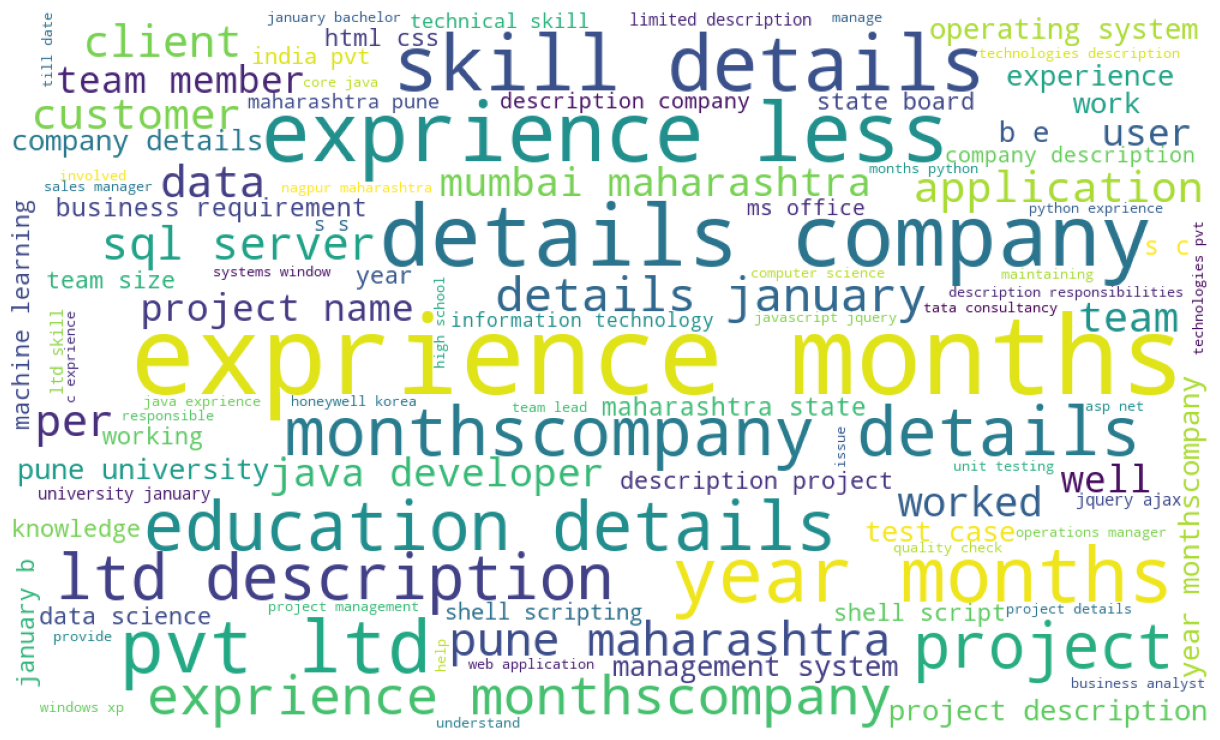

In [22]:
# Combine all cleaned resumes into a single string
all_text = ' '.join(df['cleaned resume'])

# Generate a word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=100).generate(all_text)

# Plot the word cloud
plt.figure(figsize=(12,12), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

# Show the plot
plt.show()

**Data is cleaned now.**

## Add labels of target variables

In [23]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to 'Category' column
df['Category_Labelled'] = label_encoder.fit_transform(df['Category'])

# Print the mapping of classes to encoded labels
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class to Label Mapping:")
for category, label in class_mapping.items():
    print(f"{category}: {label}")

Class to Label Mapping:
Advocate: 0
Arts: 1
Automation Testing: 2
Blockchain: 3
Business Analyst: 4
Civil Engineer: 5
Data Science: 6
Database: 7
DevOps Engineer: 8
DotNet Developer: 9
ETL Developer: 10
Electrical Engineering: 11
HR: 12
Hadoop: 13
Health and fitness: 14
Java Developer: 15
Mechanical Engineer: 16
Network Security Engineer: 17
Operations Manager: 18
PMO: 19
Python Developer: 20
SAP Developer: 21
Sales: 22
Testing: 23
Web Designing: 24


In [24]:
df.head()

,Category,Resume,cleaned resume,Category_Labelled
0,Data Science,skills * programming languages: python (pandas...,skills programming languages python pandas num...,6
1,Data Science,education details \r\nmay 2013 to may 2017 b.e...,education details may 2013 to may 2017 b.e uit...,6
2,Data Science,"areas of interest deep learning, control syste...",areas of interest deep learning control system...,6
3,Data Science,skills â¢ r â¢ python â¢ sap hana â¢ table...,skills r python sap hana tableau sap hana sql ...,6
4,Data Science,"education details \r\n mca ymcaust, faridab...",education details mca ymcaust faridabad haryan...,6


## Define independent and dependent variable

In [25]:
text = df['cleaned resume'].values
op_labels = df['Category_Labelled'].values

In [26]:
# Checking the corpus 

df['cleaned resume'].values

array(['skills programming languages python pandas numpy scipy scikitlearn matplotlib sql java javascriptjquery. machine learning regression svm nave bayes knn random forest decision trees boosting techniques cluster analysis word embedding sentiment analysis natural language processing dimensionality reduction topic modelling lda nmf pca neural nets. database visualizations mysql sqlserver cassandra hbase elasticsearch d3.js dc.js plotly kibana matplotlib ggplot tableau. others regular expression html css angular 6 logstash kafka python flask git docker computer vision open cv and understanding of deep learning.education details data science assurance associate data science assurance associate ernst young llp skill details javascript exprience 24 months jquery exprience 24 months python exprience 24 monthscompany details company ernst young llp description fraud investigations and dispute services assurance technology assisted review tar technology assisted review assists in accelerat

# Feature Encoding using TF-IDF



In [27]:
wordVectorizer = TfidfVectorizer()
wordVectorizer.fit(text)
features = wordVectorizer.transform(text)

In [28]:
wordVectorizer.get_feature_names()

['000',
 '01',
 '017',
 '02',
 '03',
 '0307',
 '04',
 '04th',
 '05',
 '050education',
 '06th',
 '07',
 '07112016',
 '07education',
 '08',
 '09',
 '09876971076',
 '0education',
 '10',
 '100',
 '101',
 '1011geducation',
 '104',
 '108',
 '109',
 '10g',
 '10grac',
 '10magicalfingers',
 '11',
 '110',
 '110v',
 '11171iec60076',
 '115',
 '118',
 '1180',
 '11g',
 '11goracle',
 '11gr2',
 '12',
 '120',
 '1200',
 '1216',
 '125',
 '12c',
 '12d',
 '12k',
 '13',
 '130',
 '132kv',
 '14',
 '147',
 '15',
 '150',
 '1500',
 '15000',
 '16',
 '163',
 '168',
 '16aug2012',
 '16th',
 '17',
 '175',
 '17th',
 '18',
 '1800',
 '1800s',
 '18aug2012',
 '18c',
 '19',
 '1900',
 '1900s',
 '1972',
 '19793',
 '1992',
 '1993',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '19xx',
 '1jan',
 '1page',
 '1st',
 '1stexpert',
 '1x',
 '1year',
 '20',
 '2000',
 '20002003',
 '20002005',
 '200020052008',
 '2000a',
 '2001',
 '2002',
 '2003',
 '200320082008',
 '2003xpvista78',
 '2004',
 '2005',
 '20052008',
 '200520082016',
 '2006',

# Divide data into train and test set

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, op_labels, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((721, 7985), (241, 7985), (721,), (241,))

In [30]:
X_train.shape, y_train.shape

((721, 7985), (721,))

# Model Building



In [31]:
# Set random state and n_jobs
random_state = 42
n_jobs = -1

# Initialize a list of classifiers with specified parameters
classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=n_jobs),
    DecisionTreeClassifier(random_state=random_state),
    KNeighborsClassifier(n_jobs=n_jobs),
    MultinomialNB(),
    AdaBoostClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    RandomForestClassifier(random_state=random_state, n_jobs=n_jobs),
    XGBClassifier(random_state=random_state, n_jobs=n_jobs),
    SVC(random_state=random_state)
]

results = []

# Loop through each classifier
for classifier in classifiers:
    start_time = time.time()
    
    # Train the classifier
    classifier.fit(X_train, y_train)
    
    # Predict on the training set
    y_pred = classifier.predict(X_train)
    
    # Calculate performance metrics
    accuracy = np.mean(y_pred == y_train)
    precision, recall, f1, _ = classification_report(y_train, y_pred, output_dict=True)['weighted avg'].values()
    balanced_acc = balanced_accuracy_score(y_train, y_pred)
    
    # Calculate the time taken for training
    build_time = time.time() - start_time
    
    # Append results to the list
    results.append([classifier.__class__.__name__, accuracy, precision, recall, f1, balanced_acc, build_time])

# Create a DataFrame from the results
columns = ["Algorithm", "Accuracy", "Precision", "Recall", "F1-score", "Balanced Accuracy", "Building Time (s)"]
results_df = pd.DataFrame(results, columns=columns)

# Print the results
print("Model Performance on Training Set")
results_df

Model Performance on Training Set


,Algorithm,Accuracy,Precision,Recall,F1-score,Balanced Accuracy,Building Time (s)
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000,1.000000,5.949510
1,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.140586
2,KNeighborsClassifier,0.984743,0.985654,0.984743,0.983960,0.977394,0.078108
3,MultinomialNB,0.950069,0.963368,0.950069,0.948090,0.929800,0.027166
4,AdaBoostClassifier,0.224688,0.158462,0.224688,0.164354,0.202000,0.705395
5,GradientBoostingClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,41.189694
6,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,0.234281
7,XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000,2.195721
8,SVC,1.000000,1.000000,1.000000,1.000000,1.000000,0.663766


In [32]:
# Initialize an empty list to store test results
test_results = []

# Loop through each classifier
for classifier in classifiers:
    # Predict on the test set
    y_pred_test = classifier.predict(X_test)
    
    # Calculate performance metrics
    accuracy_test = np.mean(y_pred_test == y_test)
    precision_test, recall_test, f1_test, _ = classification_report(y_test, y_pred_test, output_dict=True)['weighted avg'].values()
    balanced_acc_test = balanced_accuracy_score(y_test, y_pred_test)
    
    # Append results to the list
    test_results.append([classifier.__class__.__name__, accuracy_test, precision_test, recall_test, f1_test, balanced_acc_test])

# Create a DataFrame from the test results
test_columns = ["Algorithm", "Accuracy", "Precision", "Recall", "F1-score", "Balanced Accuracy"]
test_results_df = pd.DataFrame(test_results, columns=test_columns)

# Print the results
print("Model Performance on Test Set")
test_results_df

Model Performance on Test Set


,Algorithm,Accuracy,Precision,Recall,F1-score,Balanced Accuracy
0,LogisticRegression,0.987552,0.988682,0.987552,0.987207,0.992500
1,DecisionTreeClassifier,0.987552,0.988740,0.987552,0.987222,0.992500
2,KNeighborsClassifier,0.970954,0.976880,0.970954,0.970464,0.963611
3,MultinomialNB,0.921162,0.935849,0.921162,0.915094,0.874116
4,AdaBoostClassifier,0.248963,0.175306,0.248963,0.183772,0.206667
5,GradientBoostingClassifier,0.987552,0.988935,0.987552,0.987278,0.992500
6,RandomForestClassifier,0.987552,0.988956,0.987552,0.987283,0.992500
7,XGBClassifier,0.987552,0.989352,0.987552,0.987397,0.992500
8,SVC,0.987552,0.988935,0.987552,0.987278,0.992500


**I choose the Logistic Regression model because it performs well on both the training and test sets, achieving 98% accuracy, precision, recall, F1-score, and balanced accuracy. This suggests that the model effectively captures underlying patterns and generalizes well, making it a robust choice for the classification task. The LogisticRegression model also has the highest accuracy, precision, recall, and F1-score on the test set, and it has the fastest building time. Therefore, I use the LogisticRegression model for this task.**

In [33]:
# Create the Gradient Boosting Classifier model
lr = LogisticRegression(random_state=42)

lr.fit(X_train, y_train)

LogisticRegression(random_state=42)

# Model evaluation

## Model performance on train and test data

In [35]:
# Predict on the training set
y_pred_train = lr.predict(X_train)

# Calculate performance metrics for training data
report_train = classification_report(y_train, y_pred_train, output_dict=True)
accuracy_train = report_train['accuracy']
balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)
precision_train = report_train['weighted avg']['precision']
recall_train = report_train['weighted avg']['recall']
fscore_train = report_train['weighted avg']['f1-score']

# Predict on the test set
y_pred_test = lr.predict(X_test)

# Calculate performance metrics for test data
report_test = classification_report(y_test, y_pred_test, output_dict=True)
accuracy_test = report_test['accuracy']
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)
precision_test = report_test['weighted avg']['precision']
recall_test = report_test['weighted avg']['recall']
fscore_test = report_test['weighted avg']['f1-score']

# Create a DataFrame to display the results
data = {
    'Dataset': ['Train', 'Test'],
    'Accuracy': [accuracy_train, accuracy_test],
    'Balanced Accuracy': [balanced_accuracy_train, balanced_accuracy_test],
    'Precision': [precision_train, precision_test],
    'Recall': [recall_train, recall_test],
    'F1-score': [fscore_train, fscore_test]
}
results_df = pd.DataFrame(data)

# Print the results DataFrame
results_df

,Dataset,Accuracy,Balanced Accuracy,Precision,Recall,F1-score
0,Train,1.000000,1.0000,1.000000,1.000000,1.000000
1,Test,0.987552,0.9925,0.988682,0.987552,0.987207


## Classification Report

In [36]:
# Calculate classification report for training data
report_train = classification_report(y_train, y_pred_train)
print("Classification Report for Training Data:")
print(report_train)


# Calculate classification report for test data
report_test = classification_report(y_test, y_pred_test)
print("\nClassification Report for Test Data:")
print(report_test)

Classification Report for Training Data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        20
           3       1.00      1.00      1.00        29
           4       1.00      1.00      1.00        24
           5       1.00      1.00      1.00        18
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        22
           8       1.00      1.00      1.00        39
           9       1.00      1.00      1.00        22
          10       1.00      1.00      1.00        29
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00        30
          13       1.00      1.00      1.00        29
          14       1.00      1.00      1.00        22
          15       1.00      1.00      1.00        64
          16       1.00      1.00      1

## Confusion Matrix

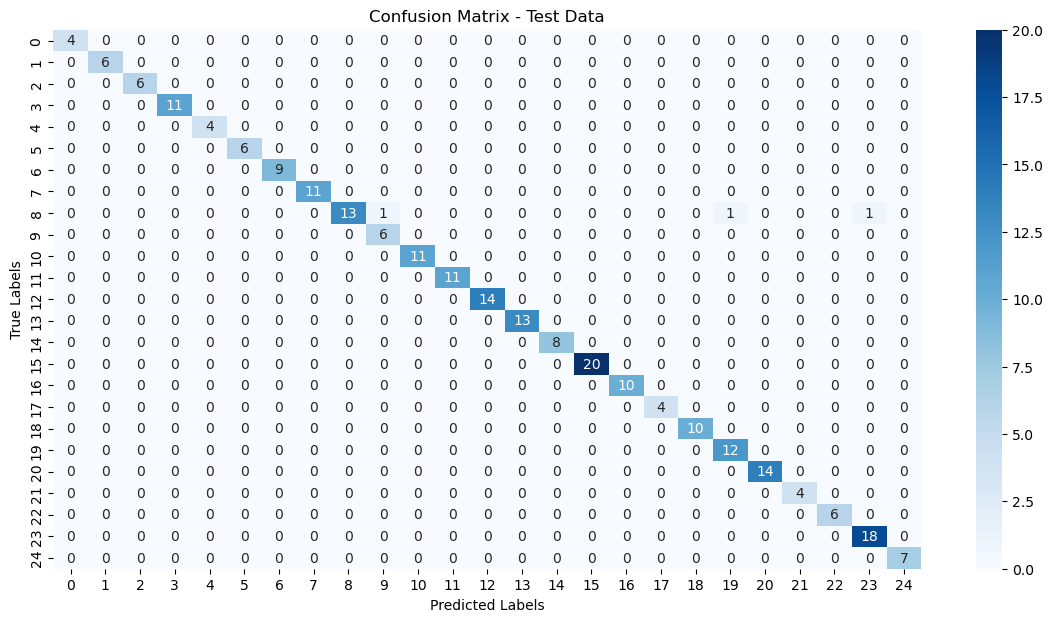

In [37]:
# Calculate confusion matrix for test data
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Display the confusion matrix using a heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Data")
plt.show()

# Cross Validation

In [39]:
#cross validation of Recall

from sklearn.model_selection import cross_val_score

scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy',n_jobs=-1)

print("Cross-Validation Scores (Accuracy):", scores)
print()
print("Mean Accuracy Score:", scores.mean())

Cross-Validation Scores (Accuracy): [1.         0.99305556 1.         0.97916667 1.        ]

Mean Accuracy Score: 0.9944444444444442


# Resume Classification Project Report
## Project Overview
In this project, we aimed to classify resumes into 25 different categories based on their content. The project involved various stages, including data preprocessing, feature engineering, and model building. The goal was to develop a model that accurately classifies resumes, facilitating efficient categorization for recruitment and analysis purposes.

### Project Steps
**Step I: Importing Libraries**

Imported essential libraries such as pandas, scikit-learn modules, and others to facilitate data manipulation, preprocessing, modeling, and evaluation.

**Step II: Importing Dataset**

The dataset containing resumes and their corresponding labels was imported for analysis and modeling.

**Step III: Data Cleaning and Preprocessing**

Noticed that certain documents contained irrelevant special characters, potentially introduced during database storage and retrieval. To address this, we performed text preprocessing steps including converting text to lowercase, removing URLs, hashtags, special characters, punctuation marks, newlines, non-ASCII characters, and leading/trailing spaces. Tokenization and stop word removal were applied to facilitate model understanding.

**Step IV: Dataset Overview**

The dataset consisted of 962 records and 25 different categories, each representing a type of resume.

**Step V: Data Cleaning Observations**

During data inspection, we observed the presence of special characters that could invalidate the resume content. This led us to implement rigorous preprocessing techniques.

**Step VI: Adding Labels to Target Variables**

Added labels to the target variables to represent the different categories of resumes.

**Step VII: Defining Independent and Dependent Variables**

Defined the independent variable (features) as the preprocessed resume text and the dependent variable as the resume categories.

**Step VIII: Feature Encoding Using TF-IDF**

Used the Term Frequency-Inverse Document Frequency (TF-IDF) technique to encode the textual data into a numeric format suitable for model training.

**Step IX: Data Splitting**

The dataset was split into training and test sets to assess model performance.

**Step X: Model Building**

Employed various classification algorithms, including Logistic Regression, Decision Tree Classifier, K-Neighbors Classifier, Multinomial Naive Bayes, AdaBoost Classifier, Gradient Boosting Classifier, Random Forest Classifier, XGBoost Classifier, and Support Vector Classifier.

**Step XI: Model Performance Evaluation**

Evaluated model performance using accuracy, precision, recall, F1-score, and balanced accuracy metrics on both the training and test sets.

**Step XII: Model Selection**

After comparing model performance, we selected the Logistic Regression model due to its consistent accuracy, precision, recall, F1-score, and balanced accuracy on both training and test datasets.

**Step XIII: Model Evaluation**

Performed a detailed evaluation of the selected model using classification reports and confusion matrices for both the training and test datasets.

**Step XIV: Cross-Validation**

Conducted cross-validation using accuracy as a metric, achieving a mean accuracy of approximately 99.44%.

**Conclusion**

Through meticulous data preprocessing, feature engineering, and comprehensive model evaluation, we successfully developed a resume classification model. The chosen Logistic Regression model demonstrated high accuracy and robust generalization, making it an optimal choice for automating the categorization of resumes for efficient recruitment processes.